In [1]:
# Carga de librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Carga de datos
df = pd.read_csv('data/csv/2022.csv')
df.head()

,DateTime,O3,CO,NO2,SO2,PM10,PM2.5,Estacion
0,01/01/2022 00:00,5.04,NaN,26.6,3.19,186.0,84.0,AGUA SANTA
1,01/01/2022 01:00,6.25,NaN,23.6,2.94,207.0,132.0,AGUA SANTA
2,01/01/2022 02:00,4.81,NaN,26.8,3.11,245.0,159.0,AGUA SANTA
3,01/01/2022 03:00,4.70,NaN,25.7,2.29,271.0,158.0,AGUA SANTA
4,01/01/2022 04:00,4.62,NaN,24.1,2.63,260.0,169.0,AGUA SANTA


In [3]:
# Revision de datos
data_types = df.dtypes
missing_values = df.isnull().sum()
data_types, missing_values

(DateTime     object
 O3          float64
 CO          float64
 NO2         float64
 SO2         float64
 PM10        float64
 PM2.5       float64
 Estacion     object
 dtype: object,
 DateTime        0
 O3           2909
 CO          16985
 NO2         13473
 SO2          8808
 PM10         7138
 PM2.5       13486
 Estacion        0
 dtype: int64)

In [4]:
# Convertir DateTime a tipo datetime
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%Y %H:%M')

# Extraer componentes de la fecha
df['Anio'] = df['DateTime'].dt.year
df['Mes'] = df['DateTime'].dt.month
df['Dia'] = df['DateTime'].dt.day
df['Hora'] = df['DateTime'].dt.hour

# Verificar duplicados
duplicated_rows = df.duplicated().sum()

# Cantidad de registros por estación
station_counts = df['Estacion'].value_counts()

duplicated_rows, station_counts

(np.int64(0),
 Estacion
 AGUA SANTA    8760
 BINE          8760
 NINFAS        8760
 UTP           8760
 VELODROMO     8760
 Name: count, dtype: int64)

In [5]:
# Resumen estadístico general para las columnas numéricas
summary_stats = df.describe()

# Calcular porcentaje de valores nulos por estación y contaminante
missing_by_station = df.groupby('Estacion')[['O3', 'CO', 'NO2', 'SO2', 'PM10', 'PM2.5']].apply(lambda x: x.isnull().mean() * 100)
summary_stats, missing_by_station


(                  DateTime            O3            CO           NO2  \
 count                43800  40891.000000  26815.000000  30327.000000   
 mean   2022-07-02 11:30:00     25.283827      1.100689     14.687103   
 min    2022-01-01 00:00:00      0.010000      0.001000      0.010000   
 25%    2022-04-02 05:45:00      9.200000      0.752000      7.900000   
 50%    2022-07-02 11:30:00     21.100000      1.116000     12.600000   
 75%    2022-10-01 17:15:00     37.240000      1.407000     19.400000   
 max    2022-12-31 23:00:00    113.500000      4.379000     82.960000   
 std                    NaN     19.378346      0.518004      9.443430   
 
                 SO2          PM10         PM2.5     Anio           Mes  \
 count  34992.000000  36662.000000  30314.000000  43800.0  43800.000000   
 mean       1.501052     37.709372     18.478904   2022.0      6.526027   
 min        0.010000      1.000000      0.100000   2022.0      1.000000   
 25%        0.800000     21.000000     10

In [18]:
estaciones = pd.read_csv('data/csv/estaciones.csv')
estaciones.head()

import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex

# Paso 1: obtener último valor medido de O3 por estación
ultima_medicion = (
    df.sort_values('DateTime')
    .groupby('Estacion')
    .tail(1)[['Estacion', 'O3']]
)

# Paso 2: unir con coordenadas
medicion_ubicada = ultima_medicion.merge(
    estaciones,
    left_on='Estacion',
    right_on='Nombre de la Estacion'
)

# Paso 3: crear mapa
m = folium.Map(location=[19.04, -98.2], zoom_start=11)
marker_cluster = MarkerCluster().add_to(m)

# Paso 4: agregar marcadores con color según valor de O3
max_valor = medicion_ubicada['O3'].max()

for _, row in medicion_ubicada.iterrows():
    color = to_hex(plt.cm.viridis(row['O3'] / max_valor)) if max_valor > 0 else "#cccccc"

    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=6,
        popup=f"{row['Estacion']}<br>O3: {row['O3']}",
        color=None,
        fill=True,
        fill_color=color,
        fill_opacity=0.8
    ).add_to(marker_cluster)

m


<Figure size 1000x600 with 0 Axes>

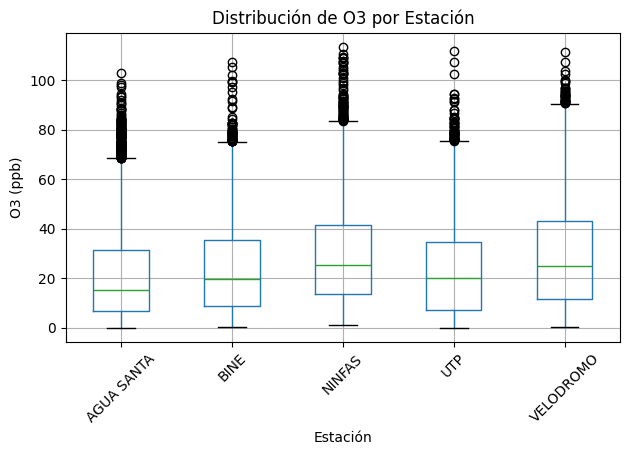

In [6]:
# Filtrar datos que no sean nulos para O3
o3_data = df.dropna(subset=['O3'])

# Crear boxplot de O3 por estación
plt.figure(figsize=(10, 6))
o3_data.boxplot(column='O3', by='Estacion')
plt.title('Distribución de O3 por Estación')
plt.suptitle('')
plt.xlabel('Estación')
plt.ylabel('O3 (ppb)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

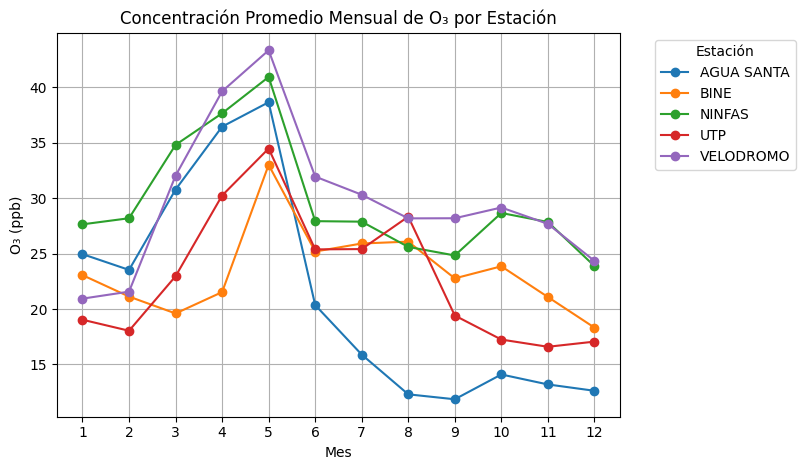

In [7]:
# Agrupar por mes y estación, calculando la media mensual de O3
monthly_o3 = df.groupby(['Mes', 'Estacion'])['O3'].mean().unstack()

# Crear gráfico de líneas para la evolución mensual de O3 por estación
plt.figure(figsize=(12, 6))
monthly_o3.plot(marker='o')
plt.title('Concentración Promedio Mensual de O₃ por Estación')
plt.xlabel('Mes')
plt.ylabel('O₃ (ppb)')
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.legend(title='Estación', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<Figure size 1200x600 with 0 Axes>

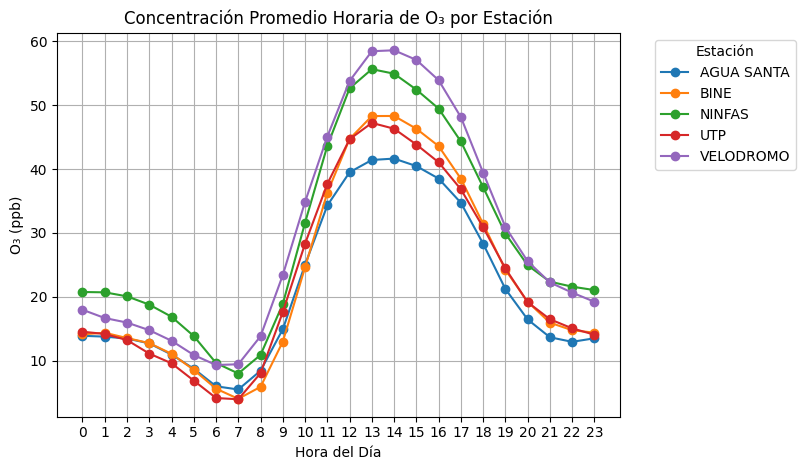

In [12]:
# Agrupar por hora y estación para obtener el promedio horario de O3
hourly_o3 = df.groupby(['Hora', 'Estacion'])['O3'].mean().unstack()

# Crear gráfico de líneas para evolución horaria de O3 por estación
plt.figure(figsize=(12, 6))
hourly_o3.plot(marker='o')
plt.title('Concentración Promedio Horaria de O₃ por Estación')
plt.xlabel('Hora del Día')
plt.ylabel('O₃ (ppb)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.legend(title='Estación', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [9]:
# Definimos un umbral alto para O3 basado en el percentil 95 (valores extremos)
threshold = df['O3'].quantile(0.95)

# Filtramos los registros que superan este umbral
high_o3_days = df[df['O3'] > threshold]

# Agrupamos por fecha para contar cuántos registros altos hubo por día
high_o3_days['Fecha'] = high_o3_days['DateTime'].dt.date
high_o3_counts = high_o3_days.groupby('Fecha').size()

# Mostrar los 10 días con más registros altos de O3
top_high_o3_days = high_o3_counts.sort_values(ascending=False).head(10)

top_high_o3_days

C:\Users\vicma\AppData\Local\Temp\ipykernel_6200\189433251.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_o3_days['Fecha'] = high_o3_days['DateTime'].dt.date


Fecha
2022-05-21    41
2022-05-19    41
2022-05-18    40
2022-05-20    36
2022-05-24    32
2022-06-04    31
2022-06-03    31
2022-05-17    31
2022-05-05    31
2022-05-03    30
dtype: int64

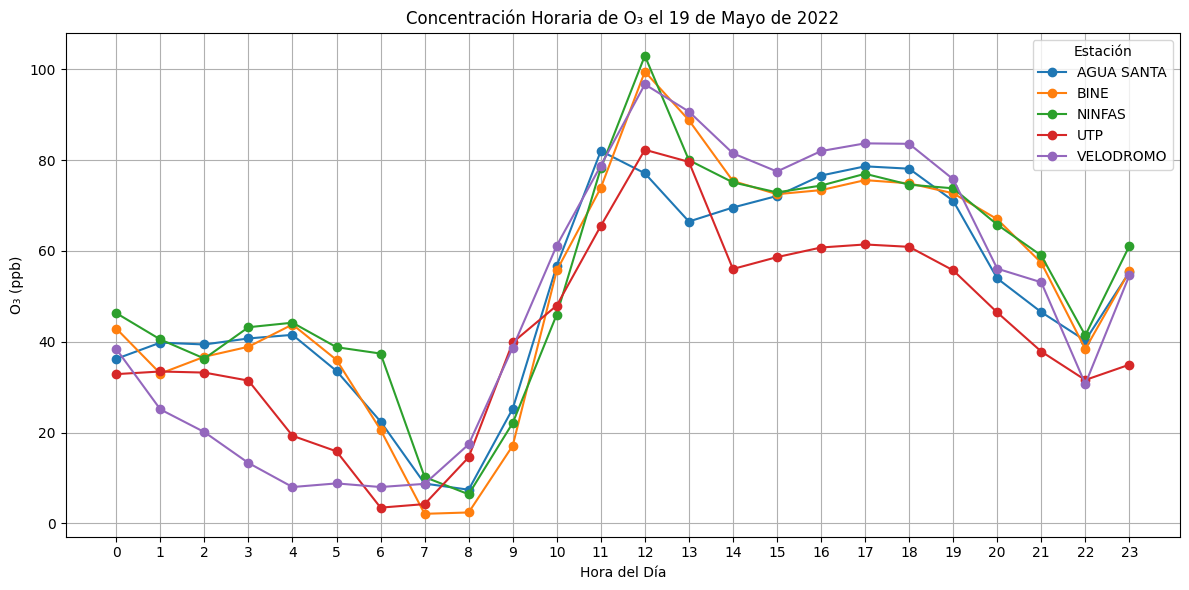

In [10]:
# Seleccionar uno de los días críticos, por ejemplo el 19 de mayo
selected_date = pd.to_datetime('2022-05-19')

# Filtrar datos para ese día
selected_day_data = df[df['DateTime'].dt.date == selected_date.date()]

# Crear gráfico de líneas del O3 por hora y estación
plt.figure(figsize=(12, 6))
for station in selected_day_data['Estacion'].unique():
    station_data = selected_day_data[selected_day_data['Estacion'] == station]
    plt.plot(station_data['Hora'], station_data['O3'], marker='o', label=station)

plt.title('Concentración Horaria de O₃ el 19 de Mayo de 2022')
plt.xlabel('Hora del Día')
plt.ylabel('O₃ (ppb)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend(title='Estación')
plt.tight_layout()
plt.show()


In [20]:
# Umbral alto para PM2.5 (percentil 95)
pm25_threshold = df['PM2.5'].quantile(0.95)

# Filtrar registros por encima del umbral
high_pm25_days = df[df['PM2.5'] > pm25_threshold]

# Agrupar por fecha
high_pm25_days['Fecha'] = high_pm25_days['DateTime'].dt.date
high_pm25_counts = high_pm25_days.groupby('Fecha').size()

# Seleccionar los 10 días con más registros elevados
top_high_pm25_days = high_pm25_counts.sort_values(ascending=False).head(10)

top_high_pm25_days


C:\Users\vicma\AppData\Local\Temp\ipykernel_6200\620309969.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_pm25_days['Fecha'] = high_pm25_days['DateTime'].dt.date


Fecha
2022-05-21    53
2022-05-20    49
2022-05-19    45
2022-01-01    35
2022-12-16    35
2022-12-17    28
2022-05-06    26
2022-12-19    25
2022-12-15    25
2022-12-14    23
dtype: int64

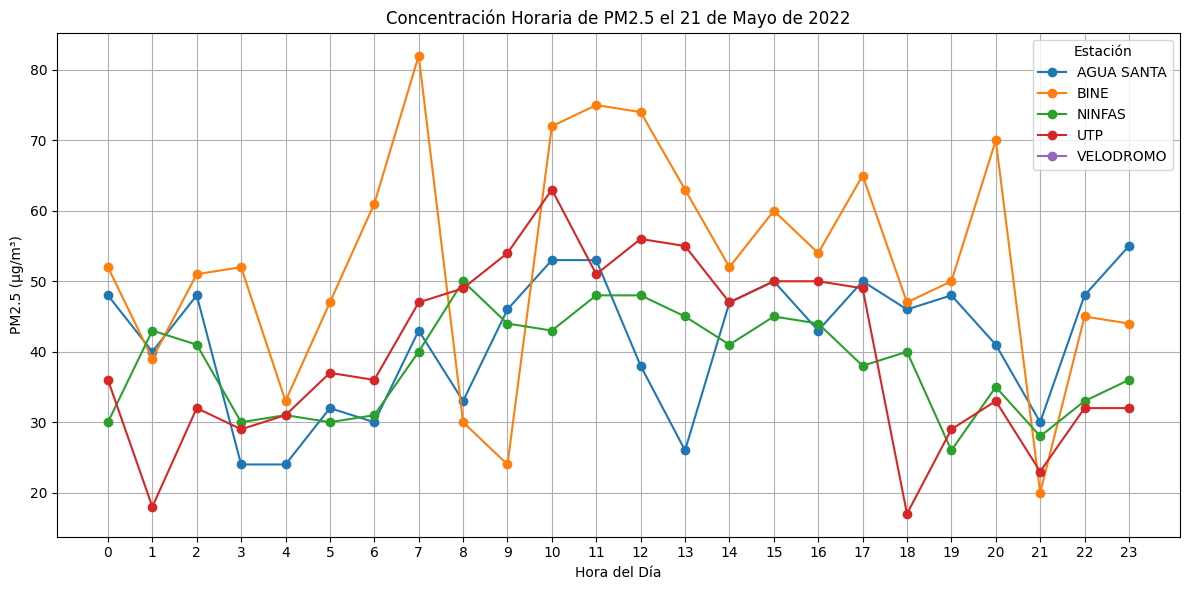

In [21]:
# Seleccionar el día 21 de mayo
selected_pm25_date = pd.to_datetime('2022-05-21')

# Filtrar datos de ese día
selected_pm25_data = df[df['DateTime'].dt.date == selected_pm25_date.date()]

# Crear gráfico de líneas del PM2.5 por hora y estación
plt.figure(figsize=(12, 6))
for station in selected_pm25_data['Estacion'].unique():
    station_data = selected_pm25_data[selected_pm25_data['Estacion'] == station]
    plt.plot(station_data['Hora'], station_data['PM2.5'], marker='o', label=station)

plt.title('Concentración Horaria de PM2.5 el 21 de Mayo de 2022')
plt.xlabel('Hora del Día')
plt.ylabel('PM2.5 (µg/m³)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend(title='Estación')
plt.tight_layout()
plt.show()


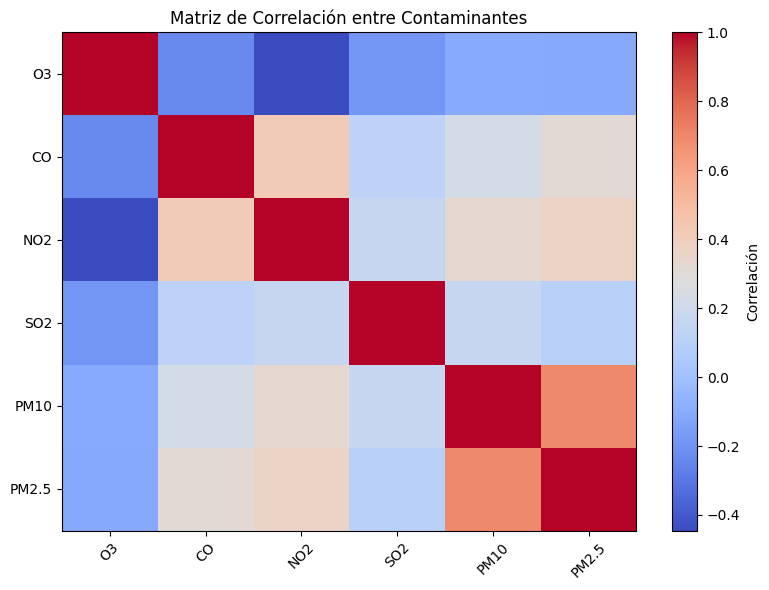

,O3,CO,NO2,SO2,PM10,PM2.5
O3,1.000000,-0.234059,-0.445094,-0.185813,-0.106332,-0.108416
CO,-0.234059,1.000000,0.413038,0.123595,0.227933,0.306672
NO2,-0.445094,0.413038,1.000000,0.160890,0.317006,0.366916
SO2,-0.185813,0.123595,0.160890,1.000000,0.162884,0.098233
PM10,-0.106332,0.227933,0.317006,0.162884,1.000000,0.692695
PM2.5,-0.108416,0.306672,0.366916,0.098233,0.692695,1.000000


In [22]:
# Filtrar solo las columnas numéricas de contaminantes
pollutants = ['O3', 'CO', 'NO2', 'SO2', 'PM10', 'PM2.5']
correlation_matrix = df[pollutants].corr()

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar(label='Correlación')
plt.xticks(range(len(pollutants)), pollutants, rotation=45)
plt.yticks(range(len(pollutants)), pollutants)
plt.title('Matriz de Correlación entre Contaminantes')
plt.tight_layout()
plt.show()

correlation_matrix


In [23]:
# Crear una copia para imputar
df_imputed = df.copy()

# Lista de contaminantes para imputar
cols_to_impute = ['O3', 'NO2', 'SO2', 'PM10', 'PM2.5']

# Aplicar interpolación lineal por estación
for col in cols_to_impute:
    df_imputed[col] = df.groupby('Estacion')[col].transform(lambda group: group.interpolate(method='linear'))

# Evaluar porcentaje restante de valores nulos tras imputación
remaining_nas = df_imputed[cols_to_impute].isnull().sum() / len(df_imputed) * 100

remaining_nas


O3        0.000000
NO2      20.011416
SO2       3.219178
PM10     10.493151
PM2.5    12.178082
dtype: float64

In [25]:
# Función corregida: imputación por promedio mensual por estación
def impute_monthly_mean_corrected(df, col):
    return df.groupby(['Estacion', 'Mes'])[col].transform(lambda x: x.fillna(x.mean()))

# Aplicar la imputación corregida a las columnas problemáticas
for col in ['NO2', 'PM10', 'PM2.5']:
    df_final_imputed[col] = impute_monthly_mean_corrected(df_final_imputed, col)

# Verificar valores faltantes finales
final_missing_corrected = df_final_imputed[['NO2', 'PM10', 'PM2.5']].isnull().sum()

final_missing_corrected


NO2      8760
PM10     4344
PM2.5    4344
dtype: int64

In [26]:
# Imputar por promedio mensual global (último recurso)
for col in ['NO2', 'PM10', 'PM2.5']:
    df_final_imputed[col] = df_final_imputed.groupby('Mes')[col].transform(lambda x: x.fillna(x.mean()))

# Verificar nuevamente los valores faltantes
final_missing_complete = df_final_imputed[['NO2', 'PM10', 'PM2.5']].isnull().sum()

final_missing_complete


NO2      0
PM10     0
PM2.5    0
dtype: int64

In [27]:
# Guardar el DataFrame limpio
df_final_imputed.to_csv('data/csv/datos_imputados.csv', index=False)
